# Analyzing and predicting nok torques given by electronic screwdrivers in a seat factory.
---
## Author: Guillermo Dean


### **Interpreter:** conda env with python 3.8.8
### **Data:** Isringhausen Spain SLU 2 months of torque results from  CVINET

---

#### Needed Nvidia CUDA  [CuDNN](https://www.tensorflow.org/install/gpu?hl=es-419) and all intallation on the link
#### to install with pip tensorflow i had to change the registry value for longpaths.

In [204]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import   LabelEncoder
from sklearn.linear_model import LogisticRegression
import numpy as np
import sklearn

## Data processing and exploration

Let's read the data set that is stored in data folder

In [205]:
df=pd.read_csv('data/Results_TTM.csv',sep=";",header=0)
df.info()


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (45,46,63) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 64 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Result status                       400000 non-null  object 
 1   Tool status                         400000 non-null  object 
 2   Step status                         0 non-null       float64
 3   Result number                       400000 non-null  int64  
 4   Time result                         400000 non-null  object 
 5   Pset ID                             399901 non-null  float64
 6   Step ID                             399901 non-null  float64
 7   Error Code                          22688 non-null   object 
 8   Stop source                         400000 non-null  object 
 9   Torque min                          399901 non-null  float64
 10  Torque                              400000 non-null  float64
 11  Torque max                

We remove all the columns with all null values

In [206]:
df=df.drop(columns=["Step status","Current trend","Torque rate min","Torque rate max","Torque rate trend","CVILOGIX","Identifier6","Identifier7","Identifier8","Identifier9","Identifier10","Second transducer torque deviation","Second transducer angle deviation","Result type","Pulse counter","Angle offset","AO torque rate"])

In [207]:
print(df.describe)
df=df[['Result status','Result number','Time result','Pset ID','Step ID','Error Code', 'Torque min','Torque','Torque max','Angle min','Angle','Angle max','Pset name','VIN','Identifier1','Identifier2','Identifier3','Identifier4','Identifier5']]

<bound method NDFrame.describe of        Result status Tool status  Result number            Time result  \
0                 OK          OK         613029  2020-12-10 23:59:12.0   
1                 OK          OK         613028  2020-12-10 23:59:08.0   
2                 OK          OK         613027  2020-12-10 23:58:56.0   
3                 OK          OK         613026  2020-12-10 23:58:48.0   
4                 OK          OK         613025  2020-12-10 23:58:41.0   
...              ...         ...            ...                    ...   
399995            OK          OK         286841  2020-09-29 18:51:08.0   
399996            OK          OK         286840  2020-09-29 18:51:03.0   
399997            OK          OK         760759  2020-09-29 18:50:45.0   
399998            OK          OK         487287  2020-09-29 18:50:40.0   
399999            OK          OK         356116  2020-09-29 18:50:37.0   

        Pset ID  Step ID Error Code     Stop source  Torque min  Torque  ... 

We are left with the columns that have interesting values and we remove all the columns that contain many nulls

In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Result status  400000 non-null  object 
 1   Result number  400000 non-null  int64  
 2   Time result    400000 non-null  object 
 3   Pset ID        399901 non-null  float64
 4   Step ID        399901 non-null  float64
 5   Error Code     22688 non-null   object 
 6   Torque min     399901 non-null  float64
 7   Torque         400000 non-null  float64
 8   Torque max     399901 non-null  float64
 9   Angle min      399901 non-null  float64
 10  Angle          400000 non-null  float64
 11  Angle max      399901 non-null  float64
 12  Pset name      399901 non-null  object 
 13  VIN            172013 non-null  object 
 14  Identifier1    172013 non-null  object 
 15  Identifier2    170608 non-null  object 
 16  Identifier3    168406 non-null  object 
 17  Identifier4    13920 non-null

We rename the columns to eliminate the spaces.

In [209]:
df=df.rename(columns={"Result status":"Result_status","Result number":"Result_number","Pset ID":"Pset_ID","Step ID":"Step_ID","Torque min":"Torque_min","Torque max":"Torque_max","Angle min":"Angle_min","Angle max":"Angle_max","Pset name":"Pset_name",'Error code':'Error_code','Result_status':'Result_status','Time result':'Time_result'})


We are going to see which of the torques are NOK, we filter the result column

In [210]:
df_nok=df[df['Result_status'].str.contains("NOK")]
df_nok.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22568 entries, 34 to 399969
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Result_status  22568 non-null  object 
 1   Result_number  22568 non-null  int64  
 2   Time_result    22568 non-null  object 
 3   Pset_ID        22568 non-null  float64
 4   Step_ID        22568 non-null  float64
 5   Error Code     22568 non-null  object 
 6   Torque_min     22568 non-null  float64
 7   Torque         22568 non-null  float64
 8   Torque_max     22568 non-null  float64
 9   Angle_min      22568 non-null  float64
 10  Angle          22568 non-null  float64
 11  Angle_max      22568 non-null  float64
 12  Pset_name      22568 non-null  object 
 13  VIN            9477 non-null   object 
 14  Identifier1    9477 non-null   object 
 15  Identifier2    9289 non-null   object 
 16  Identifier3    9301 non-null   object 
 17  Identifier4    1431 non-null   object 
 18  Iden

We have 22568 NOK results but lets see which of the Pset programmed are the ones which fails the most.

In [211]:
df_nok['Pset_name'].head()
df_nok[['Pset_name','Result_status']].groupby(by='Pset_name').count().sort_values(by=['Result_status'], ascending=False)

,Result_status
Pset_name,
Seat frame front_35Nm,1109
Armrests 28Nm,990
Slides 22Nm TX40 ISC,920
Cross angle back - Swivel_22Nm,885
Seat frame assy_35Nm_2x59-2_ISC,877
...,...
Backrest segment 22Nm ISC_A_BAU,1
Poka Yoke Check_6xxx,1
Torque_35Nm,1


The worst pset is seat fram front_35Nm with 1109 nok results
We see also that there is a POKA YOKE result, it is a forced NOK result that is done to check the tools. they must be removed from the sample.

In [212]:
df = df[~df["Pset_name"].str.contains("Poka",na=False)]

We change the type of the Time_result column to make it match the date type

In [213]:
df.astype({'Time_result': 'datetime64[ns, US/Eastern]'}).dtypes

Result_status                        object
Result_number                         int64
Time_result      datetime64[ns, US/Eastern]
Pset_ID                             float64
Step_ID                             float64
Error Code                           object
Torque_min                          float64
Torque                              float64
Torque_max                          float64
Angle_min                           float64
Angle                               float64
Angle_max                           float64
Pset_name                            object
VIN                                  object
Identifier1                          object
Identifier2                          object
Identifier3                          object
Identifier4                          object
Identifier5                          object
dtype: object

We create a new column the result column that contains the texts "NOK" and "OK" in numerical values.

In [214]:
df['Resultbin']=df['Result_status']=='OK'

In [215]:
df.head()


,Result_status,Result_number,Time_result,Pset_ID,Step_ID,Error Code,Torque_min,Torque,Torque_max,Angle_min,Angle,Angle_max,Pset_name,VIN,Identifier1,Identifier2,Identifier3,Identifier4,Identifier5,Resultbin
0,OK,613029,2020-12-10 23:59:12.0,10.0,1.0,NaN,18.0,20.126,22.0,3.0,40.213,100.0,Fixation screw_(60895R01)_20Nm_1x64-5_IF,NaN,NaN,NaN,NaN,NaN,NaN,True
1,OK,613028,2020-12-10 23:59:08.0,9.0,1.0,NaN,18.0,20.090,22.0,5.0,40.369,100.0,Fixation screw_(318327B01)_20Nm_1x64-4_I,NaN,NaN,NaN,NaN,NaN,NaN,True
2,OK,613027,2020-12-10 23:58:56.0,3.0,1.0,NaN,20.0,22.219,24.0,5.0,40.389,110.0,Sliders 22Nm_4x65-4_ISC,NaN,NaN,NaN,NaN,NaN,NaN,True
3,OK,613026,2020-12-10 23:58:48.0,3.0,1.0,NaN,20.0,22.138,24.0,5.0,33.650,110.0,Sliders 22Nm_4x65-4_ISC,NaN,NaN,NaN,NaN,NaN,NaN,True
4,OK,613025,2020-12-10 23:58:41.0,3.0,1.0,NaN,20.0,22.073,24.0,5.0,43.830,110.0,Sliders 22Nm_4x65-4_ISC,NaN,NaN,NaN,NaN,NaN,NaN,True


In [216]:
OKS = len(df[df["Result_status"].str.contains("OK",na=False)])
NOKS=len(df[df["Result_status"].str.contains("NOK",na=False)])
result=NOKS/OKS
print("NOK percentage: {:2.2%}".format(result))


NOK percentage: 5.39%


We have 5% bad torques in the whole data set.

Data is biased we have lots of OK torques against a few of NOK torques which is good for the company but not for our puroposes.
with the code below we will plot the difference between results


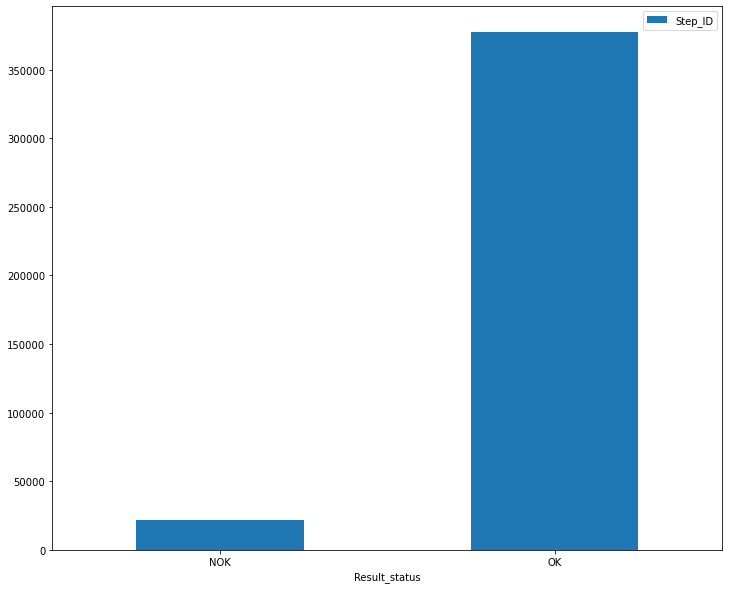

In [217]:
dfX_plot=df[['Result_status','Step_ID']].groupby(by='Result_status').count()
ax = dfX_plot.plot.bar(y='Step_ID',rot=0)

We still have columns that are not going to contribute anything to our model.

In [218]:
dfX=df.drop(columns={'Result_status','Result_number','Time_result','Pset_ID','Identifier4','Identifier5','Identifier2','Error Code','Torque','Angle'})

with df.info () we are going to see how many columns contain null results and we are going to make the whole sample have columns with data that we can use.

In [219]:
dfX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398943 entries, 0 to 399999
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Step_ID      398844 non-null  float64
 1   Torque_min   398844 non-null  float64
 2   Torque_max   398844 non-null  float64
 3   Angle_min    398844 non-null  float64
 4   Angle_max    398844 non-null  float64
 5   Pset_name    398844 non-null  object 
 6   VIN          172013 non-null  object 
 7   Identifier1  172013 non-null  object 
 8   Identifier3  168406 non-null  object 
 9   Resultbin    398943 non-null  bool   
dtypes: bool(1), float64(5), object(4)
memory usage: 30.8+ MB


Let's take a look at the values that we are going to remove. because the sample is going to be reduced a lot.

I am going to build a new colum called value_is_NAN which will contain yes or nos.

In [220]:

df_NANs=dfX[['Pset_name','Identifier1','Identifier3','Resultbin']]
df_NANs.loc[df_NANs['Identifier1'].isnull(),'value_is_NaN'] = 'Yes'
df_NANs.loc[df_NANs['Identifier1'].notnull(), 'value_is_NaN'] = 'No'
df_NANs = df_NANs[df_NANs["value_is_NaN"].str.contains("Yes",na=False)]
df_NANs[['Pset_name','Resultbin']].groupby(by='Pset_name').count().sort_values(by='Resultbin',ascending=False)



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Resultbin
Pset_name,
Sliders 22Nm_4x65-4_ISC,19342
Backrest_40Nm,10887
Seat frame assy_35Nm_2x59-2_ISC,10709
Bearing inclination cap_22Nm_2x59-1_ISC,10022
Inner carrier_22Nm_2x59-3_ISC,9927
...,...
Cushion slides_WOOD_10Nm+-2,80
Embocar Profiles 30Nm ISC,77
Slides 22Nm TX40 ISC,6


We are losing OK and NOK values from the NTS1 and NTS2 lines that do not store valueIdentifiers. In other words, the analysis will focus on the lines:
1. ALter BAU
2. Alter BUS
3. Tapizado NTS1
4. Tapizado NTS2
5. NTS1 BAU
We are going to proceed to eliminate the null results of the Df:

In [221]:
dfX=dfX.dropna()
dfX = dfX[pd.to_numeric(dfX['Identifier3'],errors='coerce').notna()]
dfX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168002 entries, 10 to 399996
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Step_ID      168002 non-null  float64
 1   Torque_min   168002 non-null  float64
 2   Torque_max   168002 non-null  float64
 3   Angle_min    168002 non-null  float64
 4   Angle_max    168002 non-null  float64
 5   Pset_name    168002 non-null  object 
 6   VIN          168002 non-null  object 
 7   Identifier1  168002 non-null  object 
 8   Identifier3  168002 non-null  object 
 9   Resultbin    168002 non-null  bool   
dtypes: bool(1), float64(5), object(4)
memory usage: 13.0+ MB


We now observe that we have 168,002 non-null records with which we can build a model. let's see the percentage of total NOK tightening.

In [222]:
dfX[['Resultbin','Step_ID']].groupby(by='Resultbin').count()

,Step_ID
Resultbin,
False,9236
True,158766


lets check again how many NOK against Ok torques we have in this dataset

In [223]:
OKS = len(df[df["Resultbin"]==True])
NOKS=len(df[df["Resultbin"]==False])
result=NOKS/OKS
print("NOK percentage: {:2.2%}".format(result))

NOK percentage: 5.70%


% of NOKs has increased but not much

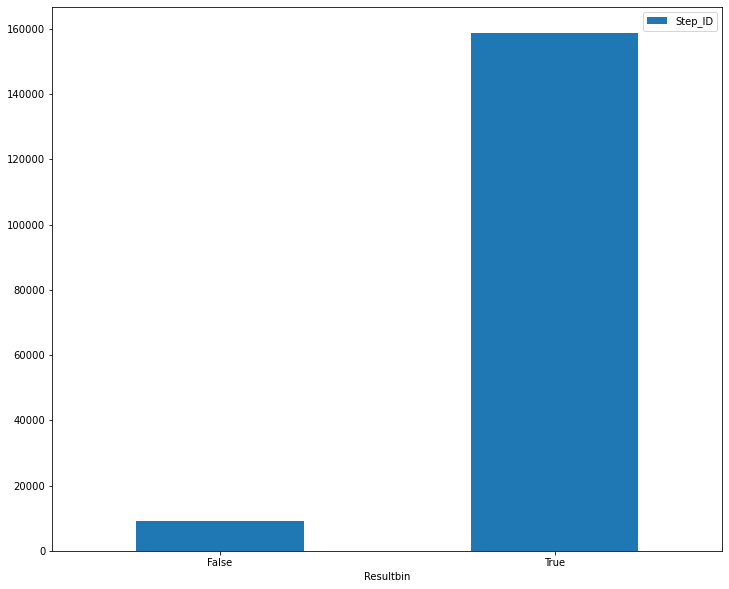

In [224]:
dfX_plot=dfX[['Resultbin','Step_ID']].groupby(by='Resultbin').count()
ax = dfX_plot.plot.bar(y='Step_ID',rot=0)

In [225]:
train_labels = np.array(dfX.pop('Resultbin'))
bool_train_labels = train_labels != 0

Finally we will have the posibility of increas NOK values in our dataset by randomly removing 10% OK values from resultbin. lets see an example

In [226]:
# df_unbias = dfX.drop(dfX[dfX['Resultbin'] == True].sample(frac=.1, random_state=101).index)

In [227]:
OKS = len(df_unbias[df_unbias["Resultbin"]==True])
NOKS=len(df_unbias[df_unbias["Resultbin"]==False])
result=NOKS/OKS
print("NOK percentage: {:2.2%}".format(result))



NOK percentage: 7.18%


We will be tuning this percentage during the model analisis to see if increasing or decreasing it will improve the predictions and metrics of the model

### Preparation of the data set for treatment.

Now we see we have labeled values (identifiers, pset...). In order for our model to work we need to convert this labels to a numerical value.
For that we will use label encoder from the sklearn library.

In [228]:

enc=LabelEncoder()
dfX=df[['Torque_min','Torque_max','Angle_min','Angle_max','Pset_name',	'Identifier1','Identifier3','Resultbin']].dropna()
dfX = dfX.drop(dfX[dfX['Resultbin'] == True].sample(frac=.1, random_state=101).index)
#Quito el 40 % de los resultados OK  de DFX

dfX['Identifier3'] = df['Identifier3'].astype('string',copy=False)
dfX['Pset_name_cat'] = enc.fit_transform(dfX['Pset_name'])
dfX['Modelo'] = enc.fit_transform(dfX['Identifier1'])
dfX[['Identifier3','Resultbin']].groupby(by="Identifier3").count()
dfX[dfX['Identifier3'].apply(lambda x: x.isnumeric())]
dfX['Trabajador'] = enc.fit_transform(dfX['Identifier3'])


In [229]:
dfX[['Identifier3','Resultbin']].groupby(by="Identifier3").count()

,Resultbin
Identifier3,
1234.0,2
1412.0,58
1505,28
1505.0,3242
2072.0,13
...,...
6000,178
6000.0,827
9385.0,3


Lets see the number of OK and NOK results we have => it will be usefull later to compare the predictions of the model with the real values.

In [230]:
dfX_gp=dfX[['Resultbin','Pset_name_cat']].groupby(by='Resultbin').count()
dfX_gp

,Pset_name_cat
Resultbin,
False,9236
True,142907


In [231]:
OKS = dfX_gp.iloc[0].values
NOKS = dfX_gp.iloc[1].values
print("OKS"+str(OKS)+" and NOKS "+str(NOKS))


OKS[9236] and NOKS [142907]


In [232]:
NOKS/OKS

array([15.47282373])

In [233]:
dfX.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 152143 entries, 10 to 399996
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Torque_min     152143 non-null  float64
 1   Torque_max     152143 non-null  float64
 2   Angle_min      152143 non-null  float64
 3   Angle_max      152143 non-null  float64
 4   Pset_name      152143 non-null  object 
 5   Identifier1    152143 non-null  object 
 6   Identifier3    152143 non-null  string 
 7   Resultbin      152143 non-null  bool   
 8   Pset_name_cat  152143 non-null  int32  
 9   Modelo         152143 non-null  int32  
 10  Trabajador     152143 non-null  int32  
dtypes: bool(1), float64(4), int32(3), object(2), string(1)
memory usage: 11.2+ MB


Ok, now we are going to leave the df with only the columns we are going to use in the model and we will start preparing our model.

In [234]:
dfX["Resultbin"] = dfX["Resultbin"].astype(int)
y=np.array(dfX["Resultbin"])
dfX=dfX.drop(columns={'Resultbin','Pset_name','Identifier1','Identifier3'})
X=dfX.values
print(y, X)



[1 1 1 ... 1 1 1] [[ 14.  18.   0. ...  70. 115.  38.]
 [ 30.  40.   0. ...  24. 115.  38.]
 [ 30.  40.   0. ...  36. 115.  38.]
 ...
 [ 30.  40.   0. ...  27.  41.  89.]
 [ 20.  24.   0. ...  21.  41.  42.]
 [ 20.  24.   0. ...  21.  41.  42.]]


You can see on the cell up that we now have one array with the results and other one with the labels already encoded as numbers.
Lets have an overview on the final data: the code below displays all the features an the correlation between them.

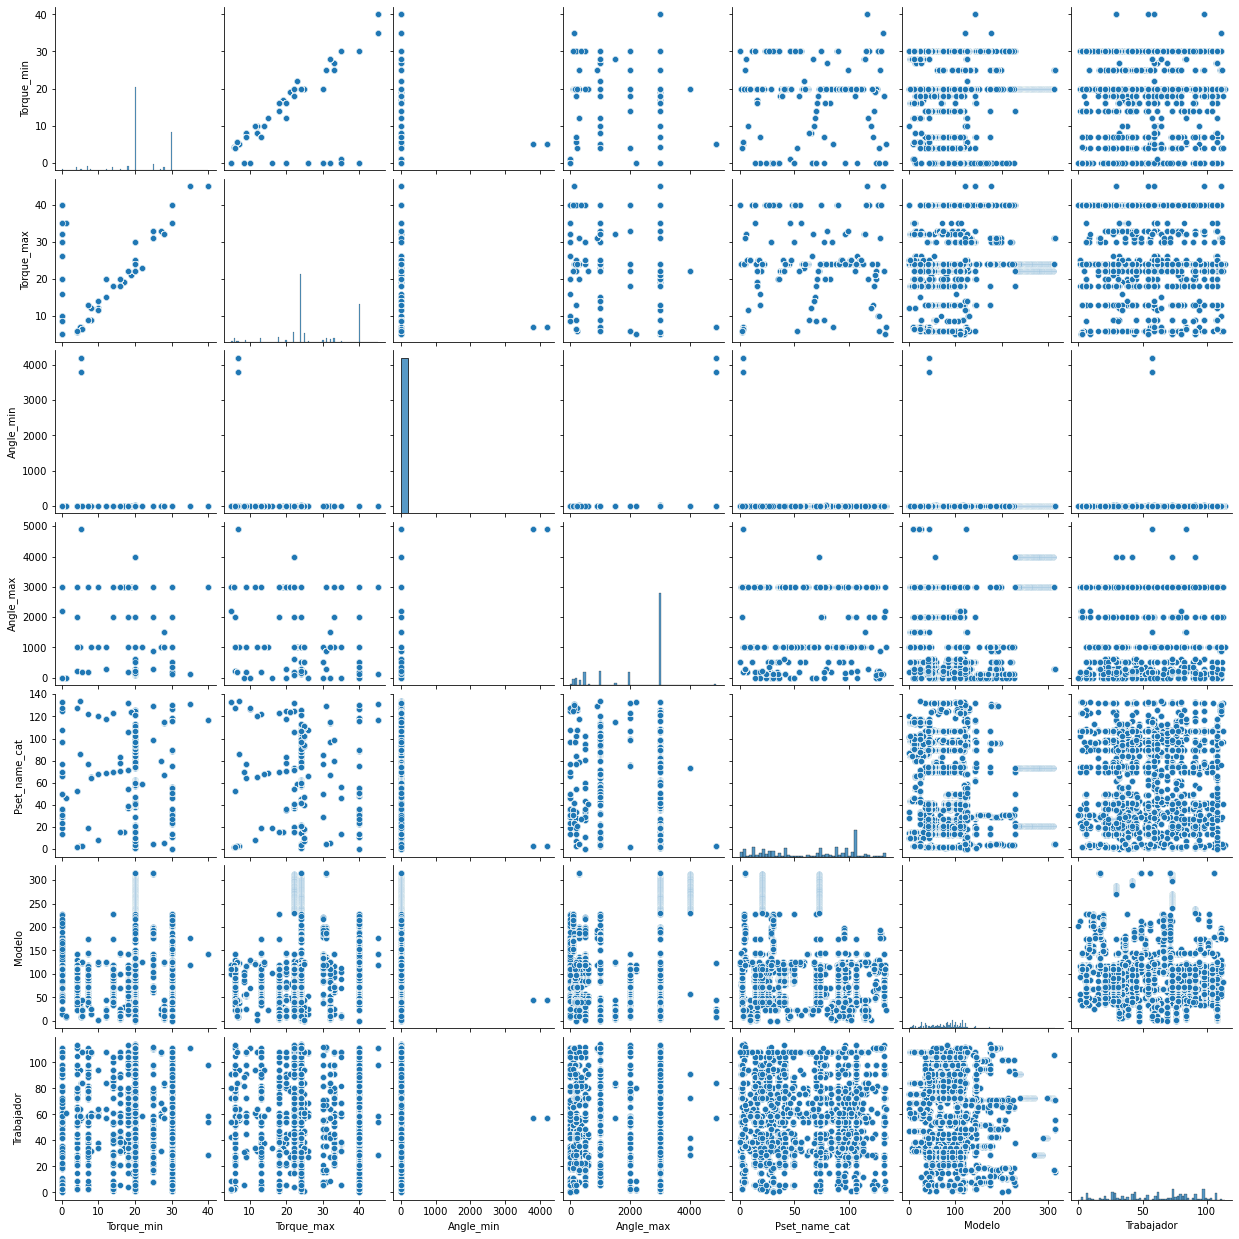

In [235]:
import seaborn as sns
sns.pairplot (dfX)

### Building the model

We are going to try to predict OK and NOK results with a neural network model. In other notebook I have already tried to use other ML learning models you can check it in my github repos.
we have to import now all the packages necesaries to build the model (tensorflow, sklearn).
We are also configuring the notebook to run the on the GPU.

In [236]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, BinaryCrossentropy
from sklearn.utils import shuffle
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs available:", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

label=np.array(y)
sample=np.array(X)

print(label.shape,sample.shape)



Num GPUs available: 1
(152143,) (152143, 7)


Neural networks preform better when the input data is in a 0 to 1 range so we will use min-max-Scaler to scale our labels.

In [237]:
label,sample =shuffle(label,sample)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_samples= scaler.fit_transform(sample) #fit transform does not accept 1D data so we reshape the scaled train samples to be 2D


We now check the shape of our arrays X and y before an after scaling

In [238]:
print(y, X)
print(y.shape,X.shape)

[1 1 1 ... 1 1 1] [[ 14.  18.   0. ...  70. 115.  38.]
 [ 30.  40.   0. ...  24. 115.  38.]
 [ 30.  40.   0. ...  36. 115.  38.]
 ...
 [ 30.  40.   0. ...  27.  41.  89.]
 [ 20.  24.   0. ...  21.  41.  42.]
 [ 20.  24.   0. ...  21.  41.  42.]]
(152143,) (152143, 7)


In [239]:
print(label,scaled_samples)
print(label.shape,scaled_samples.shape)

[1 1 1 ... 1 1 1] [[5.00000000e-01 4.75000000e-01 0.00000000e+00 ... 7.46268657e-03
  2.53164557e-01 7.98245614e-01]
 [5.00000000e-01 4.75000000e-01 1.19047619e-03 ... 7.16417910e-01
  5.91772152e-01 9.64912281e-01]
 [5.00000000e-01 4.75000000e-01 0.00000000e+00 ... 1.56716418e-01
  3.19620253e-01 7.98245614e-01]
 ...
 [5.00000000e-01 4.75000000e-01 0.00000000e+00 ... 4.70149254e-01
  4.52531646e-01 9.47368421e-01]
 [1.27500000e-01 4.75000000e-02 7.14285714e-04 ... 2.23880597e-02
  3.89240506e-01 7.36842105e-01]
 [7.50000000e-01 8.75000000e-01 0.00000000e+00 ... 6.71641791e-01
  3.10126582e-01 3.94736842e-01]]
(152143,) (152143, 7)


we are now going to use train_test_split to split arrays or matrices into random train and test subsets

In [240]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_samples, label, test_size=0.1, random_state=42)


In [241]:
print(X_test.shape, X_train.shape)
print(y_test.shape,y_train.shape)

(15215, 7) (136928, 7)
(15215,) (136928,)


## Understanding useful metrics
Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.

* **False negatives** and false positives are samples that were incorrectly classified
* **True negatives** and true positives are samples that were correctly classified
* **Accuracy** is the percentage of examples correctly classified > 
* **Precision** is the percentage of predicted positives that were correctly classified > 
* **Recall** is the percentage of actual positives that were correctly classified > 
* **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.
* **AUPRC** refers to Area Under the Curve of the Precision-Recall Curve. This metric computes precision-recall pairs for different probability thresholds.

In [242]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


## Comprender métricas útiles

Tenga en cuenta que hay algunas métricas definidas anteriormente que pueden ser calculadas por el modelo y que serán útiles al evaluar el desempeño.

* Los falsos negativos y falsos positivos son muestras que fueron clasificadas incorrectamente.

* Verdaderos negativos y positivos verdaderos son muestras que fueron clasificados correctamente.

* La precisión es el porcentaje de ejemplos correctamente clasificada.

* La precisión es el porcentaje de positivos predichos que se clasifican correctamente.

* Recall es el porcentaje de positivos reales que fueron clasificados correctamente.

* AUC se refiere al área bajo la curva de una curva característica de funcionamiento del receptor (ROC-AUC). Esta métrica es igual a la probabilidad de que un clasificador clasifique una muestra positiva aleatoria por encima de una muestra negativa aleatoria.

* AUPRC se refiere al área bajo la curva de la curva de precisión de recordar. Esta métrica calcula pares de recuperación de precisión para diferentes umbrales de probabilidad.

 # Tune model with keras tuner
 

In [243]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

we are going now to create the models using the functions make_model, model_builder and super model
What i have done here is to join two models:
* The make model is a clasification model with one last layer containing to nodes and that is evaluated with binary_crossentropy and that I used it to tune initial bias and initial weights.
* The model_builder is another model which I used to autotune hyperparameters with hyperband (This algorithm is one of the tuners available in the keras-tuner library):
    * number of units per layer
    * best epochs
    * best learning rate
Hyperband randomly sample all the combinations of hyperparameter and now instead of running full training and evaluation on it, train the model for few epochs (less than max_epochs) with these combination => its like a champions league tournament the best results advance in the competition.
* The third model is the supermodel which is a combination of the two previous models

In [244]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples.

In [245]:
def make_model(metrics=METRICS,output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    model = Sequential([
        Dense(units=16,input_shape=[len(dfX.keys())],activation='relu'),
        Dense(units=32,activation='relu'),
        Dense(units=32,activation='relu'),
        Dropout(0.5),
        Dense(units=2,activation='sigmoid',bias_initializer=output_bias)  # dos clases, par ok par nok.
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),loss='BinaryCrossentropy',metrics=metrics)
    
    # voy a cambiar el optimizer a ver si mejora 
    # from tensorflow.keras.optimizers import SGD
    # from tensorflow.keras.metrics import categorical_crossentropy
    # opt = SGD(learning_rate=0.01)
    # model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics= ['accuracy'])
    
    return model

In [246]:
def model_builder(hp):
    model = tf.keras.Sequential()

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512

    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)

    model.add(tf.keras.layers.Dense(units=16, input_shape=[
              len(dfX.keys())], activation='relu'))
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
    # added one layer more
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
    # changed to sigmoid => is equivalent to softmax for two outputs
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(
                      from_logits=True),
                  metrics=['accuracy'])

    return model


In [247]:
def super_model(hp, metrics=METRICS,output_bias=None):
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=hp_units, input_shape=[
              len(dfX.keys())], activation='relu'))
    model.add(tf.keras.layers.Dense(units=(2*hp_units)/3, activation='relu'))
    # added one layer more
    model.add(tf.keras.layers.Dense(units=hp_units/3, activation='relu'))
    # changed to sigmoid => is equivalent to softmax for two outputs
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='BinaryCrossentropy',
                  metrics=metrics)
    return model


now we define the tuner and we save the results in a folder in our src called my_dir

In [248]:
tuner = kt.Hyperband(super_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='NN_TTM')

INFO:tensorflow:Reloading Oracle from existing project my_dir\NN_TTM\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\NN_TTM\tuner0.json


In [249]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [250]:
tuner.search(X_train, y_train, epochs=50,batch_size=BATCH_SIZE , validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 64 and the optimal learning rate for the optimizer
is 0.01.



Lets look at the model once we have decided the optimal number of units of the first layer:
I have used  one of the few rules of thumb that it can be used to define hidden layers unit number:
*The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer*
I have also defined 2 as the number of hidden layers. This way it can represent an arbitrary decision boundary to arbitrary accuracy with rational activation functions and can approximate any smooth mapping to any accuracy.

In [251]:
model=super_model(hp=best_hps)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                512       
                                                                 
 dense_21 (Dense)            (None, 42)                2730      
                                                                 
 dense_22 (Dense)            (None, 21)                903       
                                                                 
 dense_23 (Dense)            (None, 1)                 22        
                                                                 
Total params: 4,167
Trainable params: 4,167
Non-trainable params: 0
_________________________________________________________________


Lets evaluate the model without initial bias

In [252]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=1)
print("Loss: {:0.4f}".format(results[0]))

67/67 [==============================] - 2s 10ms/step - loss: 0.6663 - tp: 124228.0000 - fp: 8131.0000 - tn: 171.0000 - fn: 4398.0000 - accuracy: 0.9085 - precision: 0.9386 - recall: 0.9658 - auc: 0.5708 - prc: 0.9486
Loss: 0.6663


In [253]:
results[1]

124228.0

The correct bias to set can be derived from:

In [288]:
initial_bias=np.log([OKS[0]/NOKS[0]])
initial_bias

array([-2.73908518])

We chack again the model but now with the initial bias defined previously.

In [289]:
model = super_model(hp=best_hps,output_bias=initial_bias)

In [290]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=2)
print("Lossca: {:0.4f}".format(results[0]))

67/67 - 2s - loss: 0.6336 - tp: 154134.0000 - fp: 9886.0000 - tn: 100.0000 - fn: 194.0000 - accuracy: 0.9387 - precision: 0.9397 - recall: 0.9987 - auc: 0.5180 - prc: 0.9440 - 2s/epoch - 25ms/step
Loss: 0.6336


Its aproximatedly 5% better result than the previous one, This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.  

In [257]:
# initial_bias=None
# results = model.evaluate(X_train, y_train, batch_size=10, verbose=0)
# print("Loss: {:0.4f}".format(results[0]))

We are now defining the starting control point for the weights and we are going to store them on a temp folder called initial weights

In [258]:
import tempfile
import os

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

## Train the model

Confirm that the bias fix helps

In [259]:
model = super_model(hp=best_hps)
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=2048,
    epochs=20,
    validation_split=0.1, 
    verbose=0)

In [260]:
model = super_model(hp=best_hps)
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=2048,
    epochs=20,
    validation_split=0.1, 
    verbose=0)

In [261]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [262]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

In [263]:
zero_bias_history.history

{'loss': [0.256481796503067,
  0.2162003368139267,
  0.20855063199996948,
  0.2052629441022873,
  0.1981421858072281,
  0.19641654193401337,
  0.19357170164585114,
  0.19289910793304443,
  0.19228971004486084,
  0.19042685627937317,
  0.19140087068080902,
  0.18960358202457428,
  0.18881258368492126,
  0.18824760615825653,
  0.18858769536018372,
  0.18836544454097748,
  0.18797677755355835,
  0.18777455389499664,
  0.18823854625225067,
  0.18720218539237976],
 'tp': [238122.0,
  115782.0,
  115774.0,
  115709.0,
  115761.0,
  115674.0,
  115641.0,
  115610.0,
  115574.0,
  115611.0,
  115498.0,
  115556.0,
  115570.0,
  115534.0,
  115552.0,
  115515.0,
  115504.0,
  115544.0,
  115471.0,
  115535.0],
 'fp': [15581.0,
  7444.0,
  7269.0,
  7169.0,
  7140.0,
  7080.0,
  6994.0,
  7004.0,
  6925.0,
  6980.0,
  6866.0,
  6913.0,
  6890.0,
  6866.0,
  6873.0,
  6849.0,
  6831.0,
  6851.0,
  6809.0,
  6831.0],
 'tn': [8476.0,
  9.0,
  184.0,
  284.0,
  313.0,
  373.0,
  459.0,
  449.0,
  52

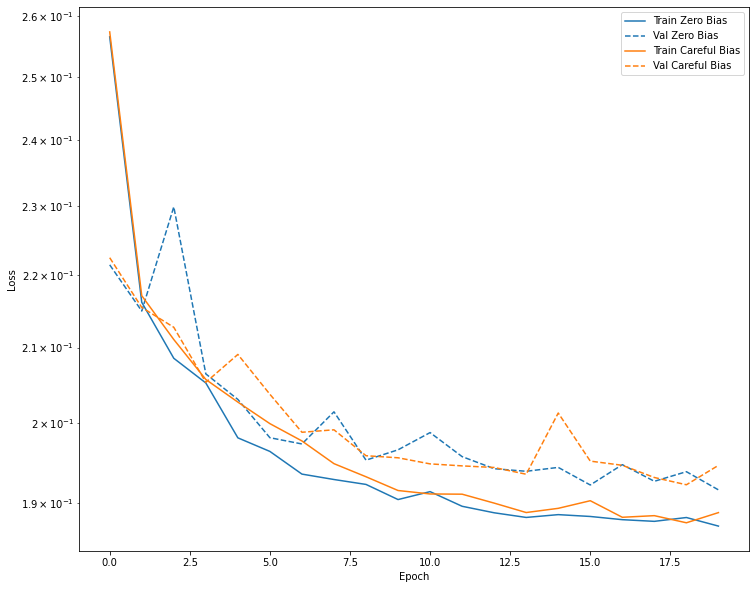

In [264]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

Entrenamiento a huevo para el modelo original

In [265]:
model = super_model(hp=best_hps)
model.load_weights(initial_weights)
baseline_history=model.fit(x=X_train,y=y_train, validation_split=0.1,batch_size=BATCH_SIZE,epochs=100,callbacks=[early_stopping] , verbose=1)



Epoch 1/100
61/61 [==============================] - 4s 34ms/step - loss: 0.2582 - tp: 126684.0000 - fp: 8152.0000 - tn: 150.0000 - fn: 1942.0000 - accuracy: 0.9263 - precision: 0.9395 - recall: 0.9849 - auc: 0.5896 - prc: 0.9516 - val_loss: 0.2214 - val_tp: 12844.0000 - val_fp: 849.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.9380 - val_precision: 0.9380 - val_recall: 1.0000 - val_auc: 0.6592 - val_prc: 0.9576
Epoch 2/100
61/61 [==============================] - 1s 14ms/step - loss: 0.2159 - tp: 115782.0000 - fp: 7425.0000 - tn: 28.0000 - fn: 0.0000e+00 - accuracy: 0.9397 - precision: 0.9397 - recall: 1.0000 - auc: 0.6647 - prc: 0.9590 - val_loss: 0.2163 - val_tp: 12844.0000 - val_fp: 830.0000 - val_tn: 19.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9394 - val_precision: 0.9393 - val_recall: 1.0000 - val_auc: 0.7017 - val_prc: 0.9655
Epoch 3/100
61/61 [==============================] - 1s 14ms/step - loss: 0.2104 - tp: 115770.0000 - fp: 7215.0000 - tn: 238.0000 - f

Esto me va a decir cual es el best epoch, reentreno el modelo definiendo el best epoch.

In [266]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50,batch_size=BATCH_SIZE, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
54/54 [==============================] - 4s 41ms/step - loss: 0.2515 - tp: 115595.0000 - fp: 7414.0000 - tn: 53.0000 - fn: 173.0000 - accuracy: 0.9384 - precision: 0.9397 - recall: 0.9985 - auc: 0.6029 - prc: 0.9544 - val_loss: 0.2216 - val_tp: 25702.0000 - val_fp: 1684.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.9385 - val_precision: 0.9385 - val_recall: 1.0000 - val_auc: 0.6494 - val_prc: 0.9565
Epoch 2/50
54/54 [==============================] - 1s 18ms/step - loss: 0.2159 - tp: 102924.0000 - fp: 6604.0000 - tn: 14.0000 - fn: 0.0000e+00 - accuracy: 0.9397 - precision: 0.9397 - recall: 1.0000 - auc: 0.6598 - prc: 0.9576 - val_loss: 0.2171 - val_tp: 25702.0000 - val_fp: 1678.0000 - val_tn: 6.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9387 - val_precision: 0.9387 - val_recall: 1.0000 - val_auc: 0.6754 - val_prc: 0.9618
Epoch 3/50
54/54 [==============================] - 1s 15ms/step - loss: 0.2113 - tp: 102923.0000 - fp: 6589.0000 - tn: 29.0000 - fn: 1.

In [267]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


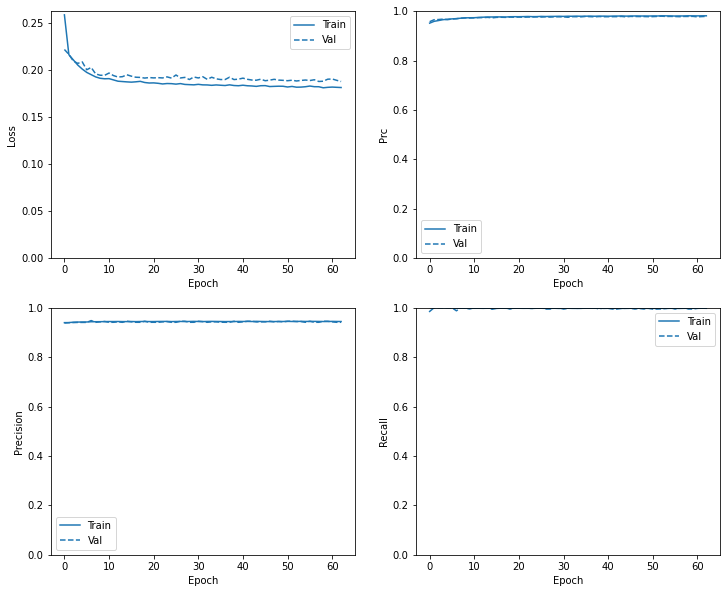

In [268]:
plot_metrics(baseline_history)

## Predictions and confusion matrix

Calculate predictions

### Predicciones del modelo con pesos y sesgo de partida

In [269]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

### Predicciones del modelo incial

In [270]:
precictions=model.predict(x=X_test.tolist(),batch_size=10,verbose=0)
print(precictions)

[[0.8739763 ]
 [0.98486555]
 [0.8483557 ]
 ...
 [0.981139  ]
 [0.950252  ]
 [0.9143433 ]]


Plot confusion matrix

In [271]:
rounded_predictions=np.argmax(precictions,axis=-1)

In [272]:

import numpy as np
import  itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    


In [273]:
from sklearn.metrics import confusion_matrix

Ploteo la confusion matrix para ver que tal ha aprendido mi modelo

Confusion matrix, without normalization
[[   649   7653]
 [   243 128383]]


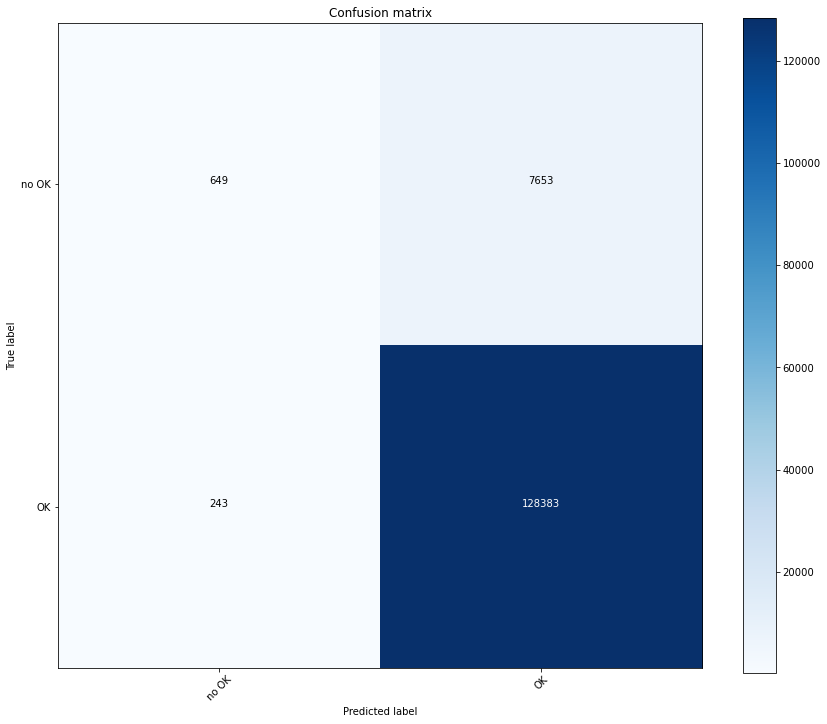

In [274]:
cm_new = confusion_matrix(y_true=y_train,y_pred=train_predictions_baseline>0.5)
cm_plot_labels=['no OK','OK']
plot_confusion_matrix (cm_new,cm_plot_labels,title='Confusion matrix')
plt.show()

In [275]:
print('NOK torques detected (True Negatives): ', cm_new[0][0])
print('NOK torques Incorrectly Detected (False Positives): ', cm_new[0][1])
print('OK torques Missed (False Negatives): ', cm_new[1][0])
print('OK torques Detected (True Positives): ', cm_new[1][1])
print('Total NOK torques: ', np.sum(cm_new[0]))

NOK torques detected (True Negatives):  649
NOK torques Incorrectly Detected (False Positives):  7653
OK torques Missed (False Negatives):  243
OK torques Detected (True Positives):  128383
Total NOK torques:  8302


# ROC

In [276]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

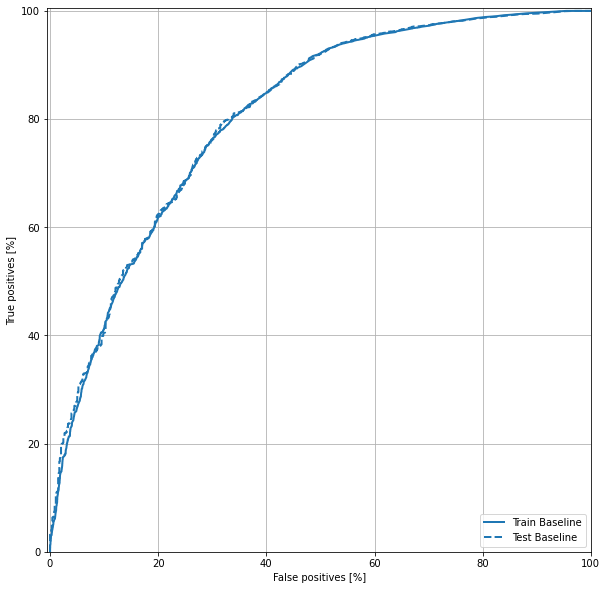

In [277]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

##  Plot the AUPRC


Now plot the AUPRC. Area under the interpolated precision-recall curve, obtained by plotting (recall, precision) points for different values of the classification threshold. Depending on how it's calculated, PR AUC may be equivalent to the average precision of the model.

In [278]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0,1.1])
    plt.ylim([0,1.1])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

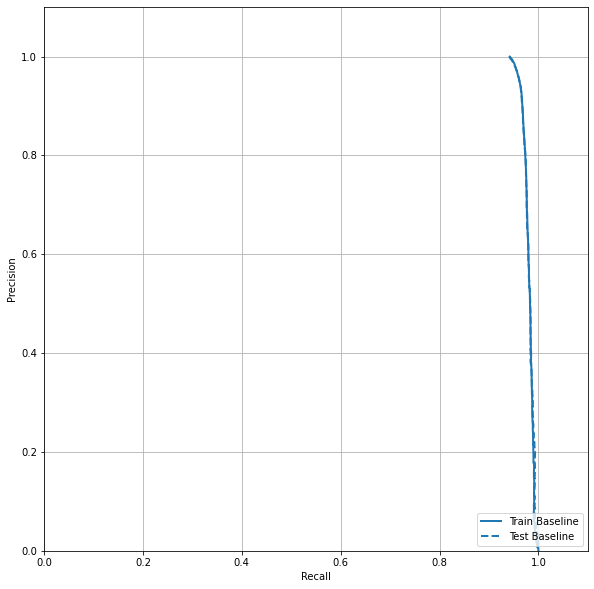

In [279]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [280]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total=OKS[0]+NOKS[0]
weight_for_0 = (1 / NOKS[0]) * (total / 2.0)
weight_for_1 = (1 / OKS[0]) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.53
Weight for class 1: 8.24


In [281]:
weighted_model = super_model(hp=best_hps)
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=best_epoch,
    callbacks=[early_stopping],
    validation_split=0.2 ,
    # The class weights go here
    class_weight=class_weight)

Epoch 1/20
54/54 [==============================] - 4s 35ms/step - loss: 0.6620 - tp: 126647.0000 - fp: 8054.0000 - tn: 248.0000 - fn: 1979.0000 - accuracy: 0.9267 - precision: 0.9402 - recall: 0.9846 - auc: 0.5396 - prc: 0.9440 - val_loss: 0.3855 - val_tp: 25702.0000 - val_fp: 1684.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.9385 - val_precision: 0.9385 - val_recall: 1.0000 - val_auc: 0.5599 - val_prc: 0.9459
Epoch 2/20
54/54 [==============================] - 1s 13ms/step - loss: 0.2095 - tp: 102924.0000 - fp: 6618.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.9396 - precision: 0.9396 - recall: 1.0000 - auc: 0.5956 - prc: 0.9515 - val_loss: 0.3314 - val_tp: 25702.0000 - val_fp: 1684.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.9385 - val_precision: 0.9385 - val_recall: 1.0000 - val_auc: 0.6153 - val_prc: 0.9531
Epoch 3/20
54/54 [==============================] - 1s 13ms/step - loss: 0.2046 - tp: 102924.0000 - fp: 6602.0000 - tn: 16.0000

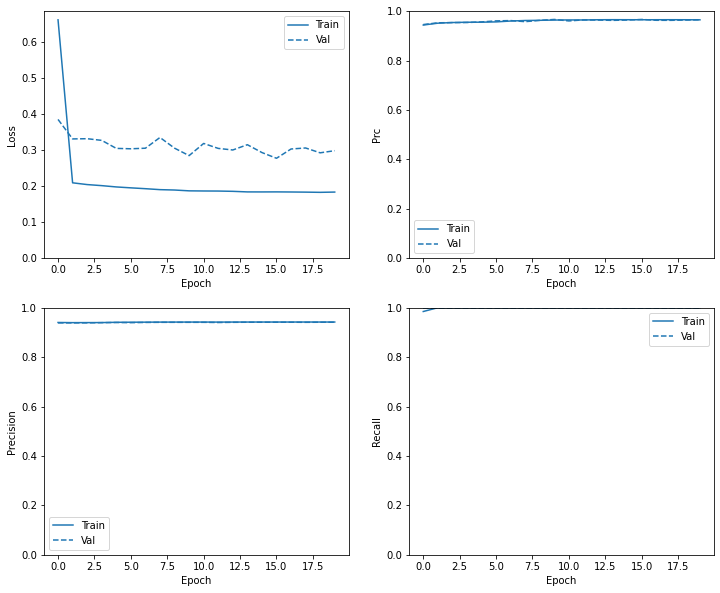

In [282]:
plot_metrics(weighted_history)

In [283]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

Confusion matrix, without normalization
[[   25   909]
 [    0 14281]]


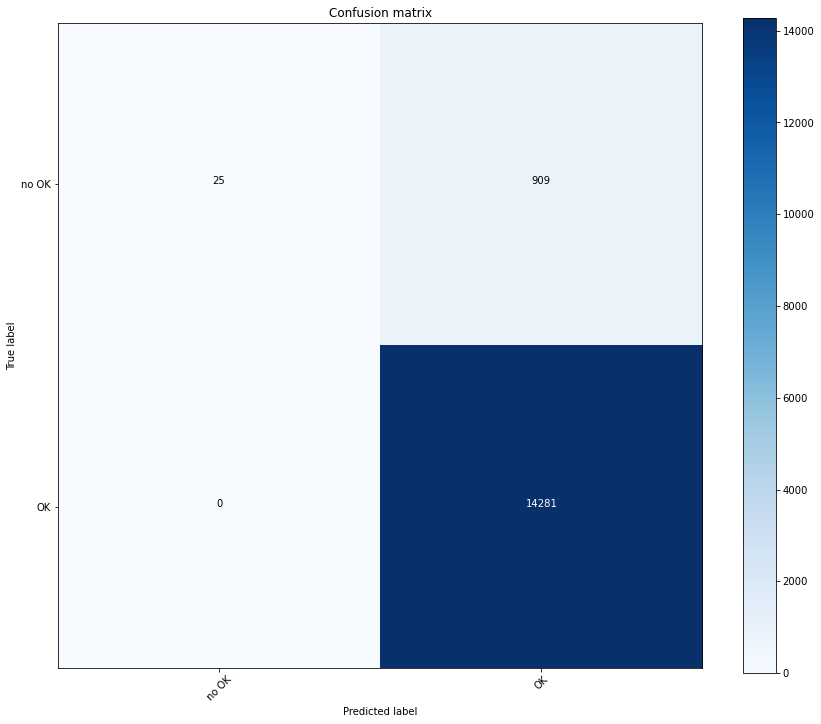

In [284]:
cm_new = confusion_matrix(y_true=y_test,y_pred=test_predictions_weighted>0.5)
cm_plot_labels=['no OK','OK']
plot_confusion_matrix (cm_new,cm_plot_labels,title='Confusion matrix')
plt.show()

## Plot ROC

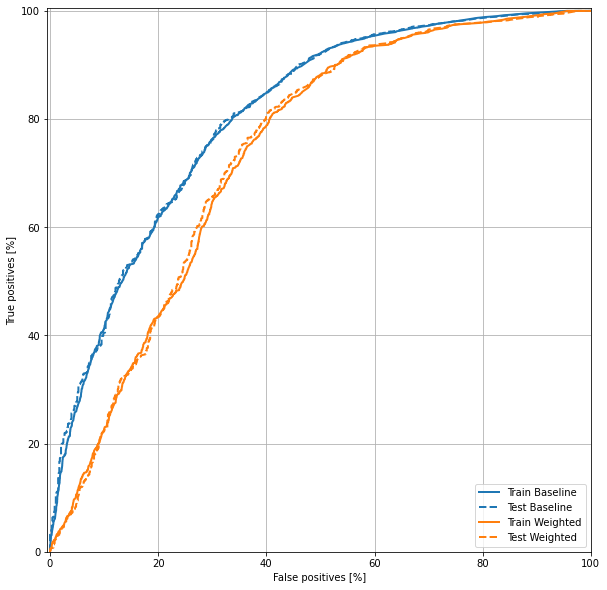

In [285]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

## Plot AUPRC

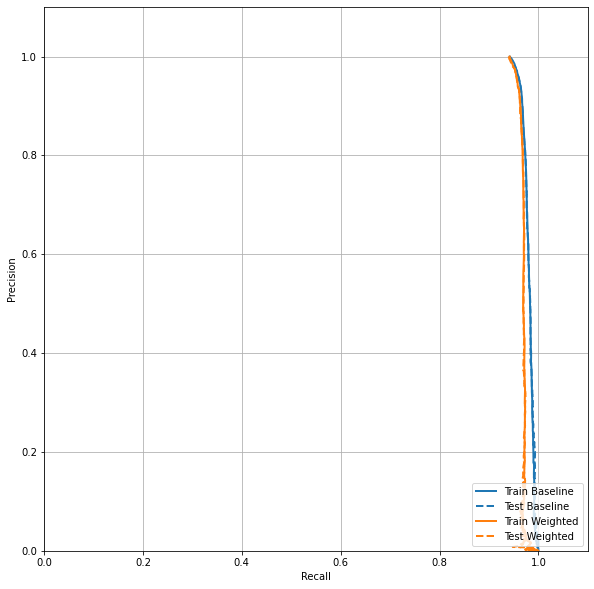

In [286]:
plot_prc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

# Oversampling

## Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.

In [287]:
pos_features = X_train[bool_train_labels]
neg_features = X_train[~bool_train_labels]

pos_labels = y_train[bool_train_labels]
neg_labels = y_train[~bool_train_labels]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 136928 but corresponding boolean dimension is 168002

You can balance the dataset manually by choosing the right number of random indices from the positive examples using numpy:

In [ ]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

Si el modelo había predicho todo a la perfección, esto sería una matriz diagonal donde los valores fuera de la diagonal principal, lo que indica predicciones incorrectas, sería cero. En este caso, la matriz muestra que tiene relativamente pocos falsos positivos

Me pasa lo mismo que con el modelo de regresion lineal => hay que tratar los datos para incrementar el numero de resultados NOK porcentualmente sobre el total de datos.

### confusion matrix logistic regresion in TTM_Pamplona

[   12,  2308]


[    0, 39686]
con todo el dataframe  Neural Network % nok predicted good = 0,005
tras reducir el número de pares Ok un 40% me sale la siguiente cm: Neural Network % nok predicted good 0.027

[   80  2905]


[    0 52462]

quitando el angulo minimo. Neural Network % nok predicted good: 0.017

[   53  3039]


[    0 52355]

vamos a volver a añadir  los pares ok a ver que hace but still i am too far

con el 60% de los pares ok quitados: Neural Network % nok predicted NOK: 0.016

[   48  3026]


[    0 52373]

vuelvo a poner el angulo mímimo.


In [ ]:
porcentaje_pares_LR=12/(12+2308)
porcentaje_pares_NN=cm[0,0]/(cm[0,0]+cm[0,1])

print("Logistic regresion % nok predicted as NOK: "+str(round(porcentaje_pares_LR,3)))
print("Neural Network % nok predicted NOK: "+str(round(porcentaje_pares_NN,3)))

1. **Use weight regularization.** It tries to keep weights low which very often leads to better generalization. Experiment with different regularization coefficients. Try 0.1, 0.01, 0.001 and see what impact they have on accuracy.


2. **Corrupt your input** (e.g., randomly substitute some pixels with black or white). This way you remove information from your input and 'force' the network to pick up on important general features. Experiment with noising coefficients which determines how much of your input should be corrupted. Research shows that anything in the range of 15% - 45% works well.


3. **Expand your training set.** Since you're dealing with images you can expand your set by rotating / scaling etc. your existing images (as suggested). You could also experiment with pre-processing your images (e.g., mapping them to black and white, grayscale etc. but the effectiveness of this technique will depend on your exact images and classes)


4. **Pre-train your layers with denoising critera.** Here you pre-train each layer of your network individually before fine tuning the entire network. Pre-training 'forces' layers to pick up on important general features that are useful for reconstructing the input signal. Look into auto-encoders for example (they've been applied to image classification in the past).


5. **Experiment with network architecture.** Your network might not have sufficient learning capacity. Experiment with different neuron types, number of layers, and number of hidden neurons. Make sure to try compressing architectures (less neurons than inputs) and sparse architectures (more neurons than inputs).

1. reducir aun mas los ok => cuanto mas?

2. meter mas layers => done

3. cambiar de softmax a sigmoid => done

4. tune hiper parameters => done

5. Ampliar el dataset con más NOK results


## Random forest clasifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

predict:

In [ ]:
prediction_rf = rf.predict(X_train)

print( np.unique( prediction_rf ) )

print( accuracy_score(y_train, prediction_rf) )

 

prob_y_4 = rf.predict_proba(X_train)
prob_y_4 = [p[1] for p in prob_y_4]
print( roc_auc_score(y_train, prob_y_4) )


parece que estamos en las mismas...

In [ ]:
prediction_rf_test=rf.predict(X_test)
cm_rf = confusion_matrix(y_true=y_test,y_pred=prediction_rf_test)
cm_plot_labels_rf=['no OK','OK']
plot_confusion_matrix (cm_rf,cm_plot_labels_rf,title='Confusion matrix Random forest clasifier')
plt.show()

In [ ]:
print(prediction_rf)

In [ ]:
estimator = rf.estimators_[5]
feature_names=[]
for col in dfX.columns:
    feature_names.append(col)

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = feature_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'],shell=False)

# Find the image on src